###Importing libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from parfit import bestFit

In [21]:
!pip install parfit

  Created wheel for parfit: filename=parfit-0.220-py3-none-any.whl size=8660 sha256=efed22ab2bf523853511d259b3cafd488ea35d55da8f08a4079aeea5a2d64d4c
  Stored in directory: /root/.cache/pip/wheels/9a/3b/19/64addee68f796a7e7108c2658a8765d600753bc728e7beb55e
Successfully built parfit


In [2]:
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

##**Data Setup & Pre-processing**

In [3]:
!gdown --id 143jlmEQqR_CFxiTPviRRLecI8Fjnuy39
!gdown --id 1urQCLkvaOSODgMzh0Fc-H2h2c1D6jS4y
!gdown --id 1gtmGhSALmKYL9AbRQ4st1EKTlZx7II_6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=143jlmEQqR_CFxiTPviRRLecI8Fjnuy39
To: /content/sample_submission.csv
100% 22.7k/22.7k [00:00<00:00, 14.5MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1urQCLkvaOSODgMzh0Fc-H2h2c1D6jS4y
To: /content/test.csv
100% 421k/421k [00:00<00:00, 32.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

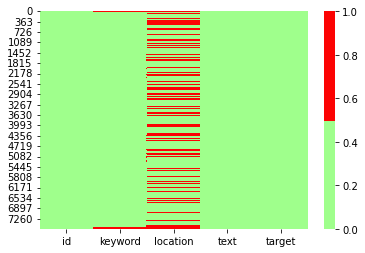

In [5]:
# Visualizing missing data points
cols = train.columns[:]
colours = ['#9fff8c', '#fc0303'] # Red is missing. green is not missing.
sns.heatmap(train[cols].isnull(), cmap=sns.color_palette(colours))
# There's a bunch of missing data for location and a little bit for keyword

In [6]:
# removing stop words (words that don't contain meaning. ex: a, the, umm)
# and lemmatize the words
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
train['filtered'] = train['text']

# function that takes a string, tokenize, removes stop words, and lemmatize the words
def text_process(txt):
  words = word_tokenize(txt)
  
  #filtered = [w for w in words if not w in stop_words]
  
  filtered = []
  for t in words:
    if t not in stop_words:
      word = lemmatizer.lemmatize(t)
      filtered.append(word)
  
  return filtered

# use the function to remove stop words & add a filtered column in the train dataframe
# also detokenize it for sklearn vectorizer
for t in range(len(train['text'])):
  train['filtered'].iloc[t] = TreebankWordDetokenizer().detokenize(text_process(train['text'].iloc[t]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
# check for the difference
train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [8]:
train['filtered'].head()

0     Our Deeds Reason #earthquake May ALLAH Forgive u
1              Forest fire near La Ronge Sask . Canada
2    All resident asked 'shelter place' notified of...
3    13,000 people receive #wildfire evacuation ord...
4    Just got sent photo Ruby #Alaska smoke #wildfi...
Name: filtered, dtype: object

In [9]:
# train test split by 75:25 split

x = train['filtered']
y = train['target']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25)

##**<font color='Cyan'>Naive Bayes</font>**

In [10]:
# count vectorize texts for both the train set and validation set
cv = CountVectorizer()
x_cvec = cv.fit_transform(x_train).toarray()
xval_cvec = cv.transform(x_val).toarray()

tf = TfidfTransformer().fit(x_cvec)
x_vec = tf.transform(x_cvec)
xval_vec = tf.transform(xval_cvec)


# tfidf = MultinomialNB()

# use multinomial naive bayes - https://www.youtube.com/watch?v=O2L2Uv9pdDA&ab_channel=StatQuestwithJoshStarmer
mnb = MultinomialNB(alpha=1)
mnb.fit(x_vec, y_train)

# score
mnb.score(xval_vec, y_val)

0.8177521008403361

In [11]:
# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(x_vec, y_train)

# score
bnb.score(xval_vec, y_val)

0.8072478991596639

In [12]:
# Gaussian Naive Bayes - https://www.youtube.com/watch?v=H3EjCKtlVog&ab_channel=StatQuestwithJoshStarmer
gnb = GaussianNB()
gnb.fit(x_cvec, y_train)

# score
gnb.score(xval_cvec, y_val)
# the score is pretty bad, so I guess the data isn't really normal

0.604516806722689

##**<font color='cyan'>Support Vector Machine</font>**

In [ ]:
# Hyperparameter tuning for SVM

# svc = SVC()

# param_grid = {'C': [.1, 1, 10],
#               'kernel': ['linear','poly', 'sigmoid','rbf']}

# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# grid.fit(x_vec,y_train)
# grid.best_params_
# this outputted {'C': 1, 'kernel': 'sigmoid'}

svc = SVC()

param_grid = {'C': [.01, .1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(x_vec,y_train)
grid.best_params_
# also got {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}

In [35]:
svc = SVC(C=1, gamma=1, kernel='sigmoid')

svc = svc.fit(x_vec, y_train)
pred = svc.predict(xval_vec);y_true = y_val

print('accuracy %s' % accuracy_score(pred, y_true))

accuracy 0.8161764705882353


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


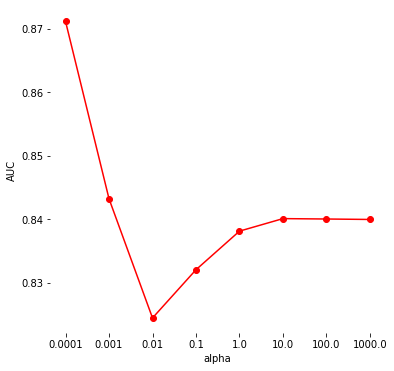

SGDClassifier(loss='log', n_jobs=-1) 0.871165123378189


In [29]:
# Training SVM using stochastic gradient descent
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = bestFit(SGDClassifier, paramGrid,
           x_vec, y_train, xval_vec, y_val, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

print(bestModel, bestScore)

87% accuracy!
It seems like this method outputs the best accuracy so far

Next step: train my own neural network (try using transformer model)